In [1]:
import pandas as pd

import config
import tqdm

In [133]:
def determine_if_row_is_control(row: pd.Series, control_df: pd.DataFrame) -> bool:
    """Given a row in the MTurk results dataframe, determine if this is a control trial"""

    if "All" in row["premises"][0]:
        return True

    control_rows = control_df[(control_df["conclusion_type"] == row["conclusion_type"]) & (control_df["domain"] == row["domain"]) & (control_df["is_single_premise"] == row["is_single_premise"])]
    
    for _, control_row in control_rows.iterrows():
        control_premise = tuple(control_row["premises"])
        control_conclusion = control_row["conclusion"]
        if tuple(control_premise) == row["premises"] and control_conclusion == row["conclusion"]:
            return True

    return False


def identify_participants_to_cut(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify participants that we should exclude from our analysis.
    
    'Light cut': participants who got more than one control trial incorrect.
    'Medium cut': Same as above, or those who gave at least 12 trials the exact same rating.
    'Hard cut': Same as above, or those who gave at least 8 trials the exact same rating.
    """

    rows = []
    for pid, pid_df in df.groupby("pid"):

        num_incorrect_controls = pid_df[(pid_df["is_control"]) & (pid_df["rating"] < 50)].shape[0]
        ratings_range = pid_df["rating"].max() - pid_df["rating"].min()
        ratings_mode = pid_df["rating"].value_counts().max()
        ratings_std = pid_df["rating"].std()

        rows.append((pid, num_incorrect_controls, ratings_range, ratings_mode, ratings_std))

    pid_cut_df = pd.DataFrame(rows, columns=["pid", "num_incorrect_controls", "ratings_range", "ratings_mode", "ratings_std"])
    pid_cut_df["light_cut"] = [row["num_incorrect_controls"] > 1 for _, row in pid_cut_df.iterrows()]
    pid_cut_df["medium_cut"] = [row["ratings_mode"] >= 12 or row["num_incorrect_controls"] > 1 for _, row in pid_cut_df.iterrows()]
    pid_cut_df["hard_cut"] = [row["ratings_mode"] >= 8 or row["num_incorrect_controls"] > 1 for _, row in pid_cut_df.iterrows()]

    output_df = df.merge(pid_cut_df[["pid", "light_cut", "medium_cut", "hard_cut"]], on="pid")
    assert output_df.shape[0] == df.shape[0]
    
    for cut_type in ("light_cut", "medium_cut", "hard_cut"):
        print(f"Number of {cut_type} participants: {pid_cut_df[pid_cut_df[cut_type]].shape[0]}/{pid_cut_df.shape[0]}")
    print()

    return output_df

In [143]:
# Load original experiment split labels
experiment_df = pd.read_csv(f"{config.DATA}/experiment_trials.csv", index_col=0)
experiment_df["pid"] = experiment_df["pid"].apply(str)
experiment_df["tid"] = experiment_df["tid"].apply(str)
experiment_df["premises"] = experiment_df["premises"].apply(lambda x: tuple(eval(x)))
experiment_df = experiment_df[experiment_df["is_osherson"] == 0].reset_index(drop=True)

# Load human ratings
human_df = pd.read_csv(f"{config.DATA}/raw_human_ratings.csv")
human_df["pid"] = human_df["tid"].apply(lambda x: x.split("participant")[-1])
human_df["tid"] = human_df["trialId"].apply(lambda x: x.replace("tc", ""))
human_df["premises"] = human_df["premises0"].apply(lambda x: tuple(x.split(":")))
human_df["conclusion"] = human_df["conclusion0"]
human_df["conclusion_type"] = human_df["conclusionType"].apply(lambda x: x.capitalize())

# Drop participants who were not paid
unpaid_participants_df = pd.read_csv(f"{config.DATA}/unpaid_participants.csv", index_col=0)
drop_uids = unpaid_participants_df[~unpaid_participants_df["paid"]]["uid"].tolist()
human_df = human_df[~human_df["uid"].isin(drop_uids)].reset_index(drop=True)

# Join human_df and experiment_df, keeping experiment_df's split labels
df = human_df.merge(experiment_df, on=["pid", "tid", "conclusion_type", "premises", "conclusion"])
df["is_single_premise"] = df["premises"].apply(lambda x: len(x) == 1)
df = df[["pid", "tid", "domain", "conclusion_type", "is_single_premise", "premises", "conclusion", "rating"]].sort_values(by=["pid", "tid"]).reset_index(drop=True)

# Do some checks
print(f"Merged df nrows: {df.shape[0]}, human_df nrows: {human_df.shape[0]}, experiment_df nrows: {experiment_df.shape[0]}")
print(f"Total number of PIDs: {len(human_df['pid'].unique())}")
missing_pids = set(experiment_df["pid"]).difference(set(human_df["pid"]))
print(f"Missing PIDs that are in experiment_df but not human_df: {missing_pids}")
assert df.shape[0] == human_df.shape[0] == experiment_df[~experiment_df["pid"].isin(missing_pids)].shape[0]
assert len(experiment_df["pid"].unique()) == len(df["pid"].unique()) + len(missing_pids)
assert all(gdf.shape[0] == 38 for _,gdf in df.groupby("pid"))
print()

# Label control trials
control_df = pd.read_csv(f"{config.DATA}/control_trials.csv", index_col=0)
control_df["premises"] = control_df["premises"].apply(lambda x: tuple(eval(x)))
print("Labelling trials as control or not control...")
df["is_control"] = [determine_if_row_is_control(row, control_df) for _, row in tqdm.tqdm(df.iterrows())]
assert all(p == 4 for p in df[df["is_control"]]["pid"].value_counts().tolist())
assert df[df["is_control"]]["pid"].value_counts().shape[0] == len(df["pid"].unique())

df = identify_participants_to_cut(df)
df["argument"] = [(row["premises"], row["conclusion"]) for _, row in df.iterrows()]
df = df[["pid", "tid",  "argument", "domain", "conclusion_type", "is_single_premise", "is_control", "premises", "conclusion", "rating", "light_cut", "medium_cut", "hard_cut"]]

134it [00:00, 1339.99it/s]

Merged df nrows: 23028, human_df nrows: 23028, experiment_df nrows: 23180
Total number of PIDs: 606
Missing PIDs that are in experiment_df but not human_df: {'58', '526', '381', '538'}

Labelling trials as control or not control...


23028it [00:18, 1260.85it/s]


Number of light_cut participants: 86/606
Number of medium_cut participants: 152/606
Number of hard_cut participants: 210/606



In [144]:
df.head()

,pid,tid,argument,domain,conclusion_type,is_single_premise,is_control,premises,conclusion,rating,light_cut,medium_cut,hard_cut
0,0,0,"((Eagles,), All birds)",Birds,General,True,False,"(Eagles,)",All birds,0,False,False,False
1,0,1,"((Crows,), All birds)",Birds,General,True,False,"(Crows,)",All birds,7,False,False,False
2,0,10,"((Vultures,), All birds)",Birds,General,True,False,"(Vultures,)",All birds,3,False,False,False
3,0,11,"((Falcons,), All birds)",Birds,General,True,False,"(Falcons,)",All birds,3,False,False,False
4,0,12,"((Herons,), All birds)",Birds,General,True,False,"(Herons,)",All birds,7,False,False,False


In [157]:
df = df[~df["medium_cut"]]
print(f"Number of participants left after medium cut: {len(df['pid'].unique())}")

df["ratings_rank"] = df.groupby(["pid", "is_single_premise"])['rating'].rank("dense", ascending=False)

rows = []
argument_labels = ["argument", "domain", "conclusion_type", "is_single_premise", "is_control", "premises", "conclusion"]
for al, arg_df in df.groupby(argument_labels):

    avg_rank = arg_df["ratings_rank"].mean()
    avg_rating = arg_df["rating"].mean()

    num_ratings = arg_df.shape[0]

    rows.append(al + (avg_rating, avg_rank, num_ratings))
    
aggregated_df = pd.DataFrame(rows, columns=argument_labels + ["average_rating", "average_ranking", "num_ratings"])
aggregated_df = aggregated_df[~aggregated_df["is_control"]].reset_index(drop=True)

# Check that number of arguments is correct and all are unique
for split, split_df in aggregated_df.groupby(["domain", "conclusion_type", "is_single_premise"]):
    domain, conclusion_type, is_single_premise = split
    if conclusion_type == "General":
        assert split_df.shape[0] == 24 if is_single_premise else split_df.shape[0] == 100
    else:
        assert split_df.shape[0] > 100 if is_single_premise else split_df.shape[0] == 100
    assert len(set(split_df["argument"].tolist())) == split_df.shape[0]
    
# Print statistics on number of arguments per split
print("Number of ratings per argument per split")
for split, split_df in aggregated_df.groupby(["domain", "conclusion_type", "is_single_premise"]):
    r = split_df["num_ratings"]
    minr, maxr, meanr, sdr = r.min(), r.max(), r.mean(), r.std()
    print(f"    {split}: min - {minr}, max - {maxr}, mean - {meanr:.2f}, sd - {sdr:.2f}")

Number of participants left after medium cut: 454
Number of ratings per argument per split
    ('Birds', 'General', False): min - 4, max - 13, mean - 6.50, sd - 2.13
    ('Birds', 'General', True): min - 65, max - 65, mean - 65.00, sd - 0.00
    ('Birds', 'Specific', False): min - 7, max - 10, mean - 8.50, sd - 0.81
    ('Birds', 'Specific', True): min - 7, max - 34, mean - 12.29, sd - 5.59
    ('Mammals', 'General', False): min - 4, max - 8, mean - 5.80, sd - 1.33
    ('Mammals', 'General', True): min - 58, max - 58, mean - 58.00, sd - 0.00
    ('Mammals', 'Specific', False): min - 8, max - 10, mean - 8.90, sd - 0.83
    ('Mammals', 'Specific', True): min - 8, max - 36, mean - 13.43, sd - 6.52
    ('Vehicles', 'General', False): min - 4, max - 8, mean - 6.60, sd - 1.29
    ('Vehicles', 'General', True): min - 66, max - 66, mean - 66.00, sd - 0.00
    ('Vehicles', 'Specific', False): min - 7, max - 10, mean - 9.10, sd - 1.14
    ('Vehicles', 'Specific', True): min - 7, max - 35, mean -

In [153]:
aggregated_df

,argument,domain,conclusion_type,is_single_premise,is_control,premises,conclusion,average_rating,average_ranking,num_ratings
0,"((Airplanes,), All vehicles)",Vehicles,General,True,False,"(Airplanes,)",All vehicles,38.136364,9.257576,66
1,"((Airplanes,), Bicycles)",Vehicles,Specific,True,False,"(Airplanes,)",Bicycles,22.285714,14.142857,7
2,"((Airplanes,), Helicopters)",Vehicles,Specific,True,False,"(Airplanes,)",Helicopters,77.875000,4.750000,8
3,"((Airplanes,), Jeeps)",Vehicles,Specific,True,False,"(Airplanes,)",Jeeps,34.250000,14.250000,8
4,"((Airplanes,), Skateboards)",Vehicles,Specific,True,False,"(Airplanes,)",Skateboards,23.187500,14.625000,16
...,...,...,...,...,...,...,...,...,...,...
1156,"((Zeppelins, Rockets), All vehicles)",Vehicles,General,False,False,"(Zeppelins, Rockets)",All vehicles,56.142857,7.000000,7
1157,"((Zeppelins, Sleds), Caravans)",Vehicles,Specific,False,False,"(Zeppelins, Sleds)",Caravans,53.250000,6.250000,8
1158,"((Zeppelins, Submarines), All vehicles)",Vehicles,General,False,False,"(Zeppelins, Submarines)",All vehicles,47.333333,6.666667,6
1159,"((Zeppelins, Tractors), All vehicles)",Vehicles,General,False,False,"(Zeppelins, Tractors)",All vehicles,51.000000,4.625000,8


# Test rerun

In [56]:
import seaborn as sns

3481


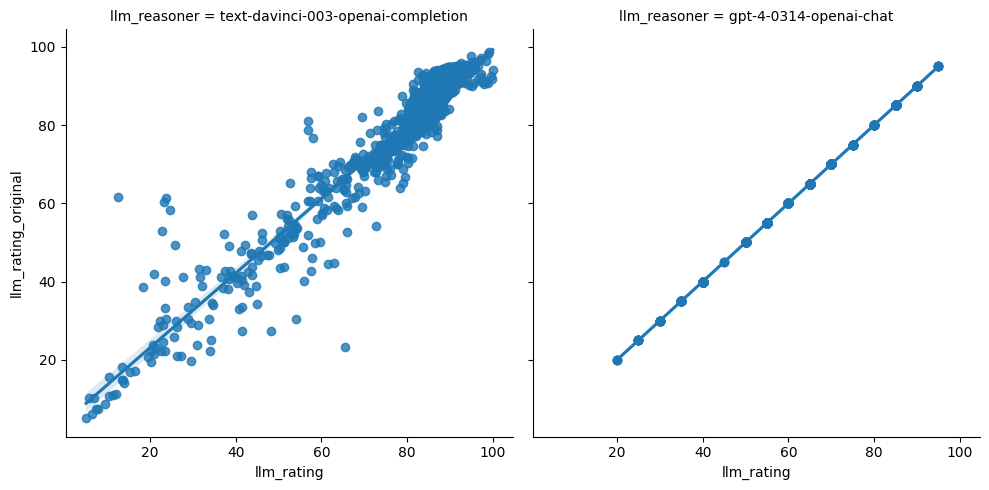

In [57]:
df1 = pd.read_csv("../data/experiment_2/llm_ratings.csv", index_col=0)
df2 = pd.read_csv("../data/experiment_2/model_ratings.csv", index_col=0)
df2 = df2[df2["prompt_generator"] == "S3-C1-A1-Q1-O1-T"]

rows = []
for _, row in df2.iterrows():
    rows.append(("text-davinci-003-openai-completion", row["argument_id"], row["gpt3_rating"]))
    rows.append(("gpt-4-0314-openai-chat", row["argument_id"], row["gpt4_rating"]))
df2 = pd.DataFrame(rows, columns=["llm_reasoner", "argument", "llm_rating_original"])
df1 = df1[["llm_reasoner", "argument", "llm_rating"]].dropna()

print(len(df1))

jdf = df1.merge(df2, on=["llm_reasoner", "argument"])
sns.lmplot(x="llm_rating", y="llm_rating_original", col="llm_reasoner", data=jdf)


In [54]:
df35 = pd.read_csv("/Users/jerome/Desktop/llm_ratings_gpt35.csv", index_col=0)
df3 = pd.read_csv("/Users/jerome/Desktop/llm_ratings_gpt3.csv", index_col=0)
df4 = pd.read_csv("/Users/jerome/Desktop/llm_ratings_gpt4.csv", index_col=0)

df4 = df4[df4["prompt_generator"] == "S3-C1-A1-Q4-O1-T"]
args = set(df3["argument"])
df4 = df4[df4["argument"].isin(args)]

assert set(df3["argument"]) == set(df4["argument"])

df4["llm_reasoner"] = ["gpt-4-0314-openai-chat"] * len(df4)
df4["llm_model"] = ["gpt-4-0314"] * len(df4)

control_df = df35[["argument", "is_control", "conclusion_type", "is_single_premise"]]
df4 = df4.merge(control_df, on="argument")
df4["llm_raw_completion"] = df4["completion"]
df4["prompt"] = df4["message"]
df4["llm_rating"] = df4["parsed_answer"]

l = len(df4)
df4 = df4[df35.columns]
assert len(df4) == l

df = pd.concat([df3,df35,df4], ignore_index=True)
df.to_csv("../data/experiment_2/llm_ratings.csv")

In [59]:
df1 = pd.read_csv("../data/experiment_2/llm_prompts.csv", index_col=0)
df2 = pd.read_csv("../data/experiment_2/llm_ratings.csv", index_col=0)

In [66]:
df3 = df1[["argument", "llm_model", "prompt"]].merge(df2[["argument", "llm_model", "prompt"]], on=["argument", "llm_model"])
df3 = df3[df3["llm_model"] == "gpt-4-0314"]
df3[df3["prompt_x"] != df3["prompt_y"]]



,argument,llm_model,prompt_x,prompt_y
1,"(('Airplanes',), 'All vehicles')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
4,"(('Airplanes',), 'Bicycles')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
7,"(('Airplanes',), 'Helicopters')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
10,"(('Airplanes',), 'Jeeps')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
13,"(('Airplanes',), 'Skateboards')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
...,...,...,...,...
3469,"(('Zeppelins', 'Rockets'), 'All vehicles')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
3472,"(('Zeppelins', 'Sleds'), 'Caravans')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
3475,"(('Zeppelins', 'Submarines'), 'All vehicles')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."
3478,"(('Zeppelins', 'Tractors'), 'All vehicles')",gpt-4-0314,"[{'role': 'system', 'content': ""You are an exp...","[{'role': 'system', 'content': ""You are an exp..."


In [68]:
eval(df3["prompt_x"].iloc[0])

[{'role': 'system',
  'content': "You are an expert on objects and the types of real world properties that they have. The questions you'll see don't have right or wrong answers, and you are willing to use your best judgment and commit to a concrete, specific response even in cases where you can't be sure that you are correct."},
 {'role': 'user',
  'content': 'We\'re going to show you a series of claims relating to objects and the properties they share. Rather than mention any specific property (e.g. "Hyenas have sesamoid bones") we\'ll refer to an unspecified property (e.g. "Hyenas have property P"). Each claim may be true or false, and to help you decide which, we\'ll provide you with facts about whether or not other objects have the same property (e.g. "Lions have property P", and "Zebras have property P").\n\nThis section contains a series of claims that include only one supporting fact. Before we start, we\'ll give you two examples as practice.\n\nArgument A:\nFact - Papayas have 

In [69]:
eval(df3["prompt_y"].iloc[0])

[{'role': 'system',
  'content': "You are an expert on objects and the types of real world properties that they have. The questions you'll see don't have right or wrong answers, and you are willing to use your best judgment and commit to a concrete, specific response even in cases where you can't be sure that you are correct."},
 {'role': 'user',
  'content': 'We\'re going to show you a series of claims relating to objects and the properties they share. Rather than mention any specific property (e.g. "Hyenas have sesamoid bones") we\'ll refer to an unspecified property (e.g. "Hyenas have property P"). Each claim may be true or false, and to help you decide which, we\'ll provide you with facts about whether or not other objects have the same property (e.g. "Lions have property P", and "Zebras have property P").\n\nThis section contains a series of claims that include only one supporting fact. Before we start, we\'ll give you two examples as practice.\n\nArgument A:\nFact - Papayas have 

# e2_generate_model_results.py

In [12]:
import config
import pandas as pd
import numpy as np

from typing import List, Dict


def get_similarity(
    a: str, 
    b: str, 
    sim_map: Dict
) -> float:
    """Return similarity between two categories, a and b"""
    if a in sim_map and b in sim_map[a]:
        return sim_map[a][b]
    elif b in sim_map and a in sim_map[b]:
        return sim_map[b][a]
    else:
        return 0.0
  

def scm(
    premises: List[str], 
    c: str, 
    all_c: List[str], 
    sim_map: Dict[str, Dict[str,float]], 
    specific: bool = True, 
    alpha: float = 0.5
) -> float:
    """Calculate SCM score of a given argument"""

    if not specific:
        conclusion_categories_1 = all_c
    else:
        conclusion_categories_1 = [c]
    a = np.mean([
            np.max([
                get_similarity(p, c_cat, sim_map)
                for p in premises if p
            ])
            for c_cat in conclusion_categories_1
    ])
        
    # calculate b
    conclusion_categories_2 = all_c
    b = np.mean([
            np.max([
                get_similarity(p, c_cat, sim_map)
                for p in premises if p
            ])
            for c_cat in conclusion_categories_2
    ]) 
    
    return alpha*a + (1-alpha)*b



domain_categories = config.load_map(f"{config.DEDEYNE_DATA}/domain_categories.json")
similarity_maps = {
    "gpt3": config.load_map(f"{config.DATA}/gpt3_similarity_map.json"),
    "gpt4": config.load_map(f"{config.DATA}/gpt4_similarity_map.json"),
    "human": config.load_map(f"{config.DEDEYNE_DATA}/similarity_map.json")
}

# Flatten existing human similarity map, which is split by domains
human_similarity_map = {}
for k,v in similarity_maps["human"].items():
    for k1,v1 in v.items():
        human_similarity_map[k1] = v1
similarity_maps["human"] = human_similarity_map

llm_rating_df = pd.read_csv(f"{config.E2_DATA}/llm_ratings.csv", index_col=0)
llm_rating_df["premises"] = llm_rating_df["premises"].apply(eval)

rows = []
for argument, argument_df in llm_rating_df.groupby("argument"):
    
    r = argument_df.iloc[0]
    domain, conclusion_type, premises, conclusion, is_single_premise = r["domain"], r["conclusion_type"], r["premises"], r["conclusion"], r["is_single_premise"]
    
    gpt3_rating = argument_df[argument_df["llm_model"] == "text-davinci-003"]["llm_rating"].iloc[0]
    gpt35_rating = argument_df[argument_df["llm_model"] == "gpt-3.5-turbo-0613"]["llm_rating"].iloc[0]
    gpt4_rating = argument_df[argument_df["llm_model"] == "gpt-4-0314"]["llm_rating"].iloc[0]
    
    rows.append((argument, domain, conclusion_type, is_single_premise, premises, conclusion, gpt3_rating, gpt35_rating, gpt4_rating))

model_df = pd.DataFrame(rows, columns=["argument", "domain", "conclusion_type", "is_single_premise", "premises", "conclusion", "gpt3_rating", "gpt3.5_rating", "gpt4_rating"])

# MaxSim
for agent, agent_similarity_map in similarity_maps.items():
    model_df[f"{agent}_maxsim"] = [
        np.max([
            agent_similarity_map[p][row["conclusion"]]
            for p in row["premises"]
        ])
        if row["conclusion_type"] == "Specific"
        else None
        for _, row in model_df.iterrows()
    ]

# MeanSim
for agent, agent_similarity_map in similarity_maps.items():
    model_df[f"{agent}_meansim"] = [
        np.mean([
            agent_similarity_map[p][row["conclusion"]]
            for p in row["premises"]
        ])
        if row["conclusion_type"] == "Specific"
        else None
        for _, row in model_df.iterrows()
    ]

# SCM
ALPHA = 0.5
scm_score_maps = {agent: {} for agent in similarity_maps}
for cdsp, tdf in model_df.groupby(["conclusion_type", "domain", "is_single_premise"]):
    conclusion_type, domain, is_single_premise = cdsp
    for agent, agent_similarity_map in similarity_maps.items():

        scm_scores = []
        for _, row in tdf.iterrows():
            try:
                scm_score = scm(
                    row["premises"], 
                    row["conclusion"], 
                    domain_categories[domain], 
                    agent_similarity_map, 
                    row["conclusion_type"] == "Specific",
                    alpha=ALPHA
                )
                scm_scores.append(scm_score)
            except:
                scm_scores.append(None)

        for i, row in tdf.reset_index(drop=True).iterrows():
            scm_score_maps[agent][row["argument"]] = scm_scores[i]

for agent, scm_score_map in scm_score_maps.items():
    model_df[f"{agent}_scm"] = [scm_score_map[row["argument"]] for _, row in model_df.iterrows()]

assert len(model_df) == len(llm_rating_df) / len(set(llm_rating_df["llm_model"]))
assert set(model_df["argument"]) == set(llm_rating_df["argument"])


In [13]:
model_df

,argument,domain,conclusion_type,is_single_premise,premises,conclusion,gpt3_rating,gpt3.5_rating,gpt4_rating,gpt3_maxsim,gpt4_maxsim,human_maxsim,gpt3_meansim,gpt4_meansim,human_meansim,gpt3_scm,gpt4_scm,human_scm
0,"(('Airplanes', 'Buses'), 'All vehicles')",Vehicles,General,False,"[Airplanes, Buses]",All vehicles,59.515127,50.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,9.769913,10.916667,10.772222
1,"(('Airplanes', 'Helicopters'), 'All vehicles')",Vehicles,General,False,"[Airplanes, Helicopters]",All vehicles,32.105938,50.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,8.313786,7.666667,8.063889
2,"(('Airplanes', 'Taxis'), 'All vehicles')",Vehicles,General,False,"[Airplanes, Taxis]",All vehicles,63.641823,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,9.363121,10.583333,10.622222
3,"(('Airplanes', 'Trams'), 'Trains')",Vehicles,Specific,False,"[Airplanes, Trams]",Trains,98.796711,100.0,85.0,15.046438,15.0,16.533333,11.786166,11.25,12.233333,12.175505,12.260417,13.163889
4,"(('Airplanes', 'Zeppelins'), 'All vehicles')",Vehicles,General,False,"[Airplanes, Zeppelins]",All vehicles,28.767269,90.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,7.396477,7.541667,8.252778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,"(('Zeppelins',), 'Buses')",Vehicles,Specific,True,[Zeppelins],Buses,75.161184,0.0,40.0,7.520618,4.5,7.400000,7.520618,4.50,7.400000,6.747038,4.552083,7.225000
1157,"(('Zeppelins',), 'Caravans')",Vehicles,Specific,True,[Zeppelins],Caravans,64.344713,0.0,40.0,3.116001,4.0,7.000000,3.116001,4.00,7.000000,4.544729,4.302083,7.025000
1158,"(('Zeppelins',), 'Mopeds')",Vehicles,Specific,True,[Zeppelins],Mopeds,20.717422,0.0,30.0,1.000805,2.0,5.266667,1.000805,2.00,5.266667,3.487131,3.302083,6.158333
1159,"(('Zeppelins',), 'Skateboards')",Vehicles,Specific,True,[Zeppelins],Skateboards,22.794046,0.0,20.0,2.739261,2.0,4.133333,2.739261,2.00,4.133333,4.356359,3.302083,5.591667


In [19]:
[x for x in human_similarity_map if "air" in x]

[]

In [3]:
llm_rating_df

,llm_reasoner,llm_model,argument,domain,conclusion_type,is_single_premise,is_control,premises,conclusion,prompt,llm_raw_completion,llm_rating
0,text-davinci-003-openai-completion,text-davinci-003,"(('Trams', 'Jeeps'), 'All vehicles')",Vehicles,General,False,False,"['Trams', 'Jeeps']",All vehicles,You are an expert on objects and the types of ...,"{\n ""id"": ""cmpl-7UdGDzexyrN7IcrkIfg5Qll3RhRPx...",65.329936
1,text-davinci-003-openai-completion,text-davinci-003,"(('Taxis',), 'Mopeds')",Vehicles,Specific,True,False,['Taxis'],Mopeds,You are an expert on objects and the types of ...,"{\n ""id"": ""cmpl-7UdGCyrmWGzLGtvGCZChTupMwDmNW...",77.383367
2,text-davinci-003-openai-completion,text-davinci-003,"(('Cars', 'Bicycles'), 'Carriages')",Vehicles,Specific,False,False,"['Cars', 'Bicycles']",Carriages,You are an expert on objects and the types of ...,"{\n ""id"": ""cmpl-7UdGCqqerht3wSIxGoq2SS94rIpnI...",82.078128
3,text-davinci-003-openai-completion,text-davinci-003,"(('Cows',), 'Donkeys')",Mammals,Specific,True,False,['Cows'],Donkeys,You are an expert on living things and the typ...,"{\n ""id"": ""cmpl-7UdGCotzyQRU7rQKij3AIXpedP9Om...",87.096898
4,text-davinci-003-openai-completion,text-davinci-003,"(('Taxis', 'Boats'), 'Carts')",Vehicles,Specific,False,False,"['Taxis', 'Boats']",Carts,You are an expert on objects and the types of ...,"{\n ""id"": ""cmpl-7UdGCjTzfmytduxNhJ6VOLp76osbl...",79.461523
...,...,...,...,...,...,...,...,...,...,...,...,...
3478,gpt-4-0314-openai-chat,gpt-4-0314,"(('Zeppelins',), 'Buses')",Vehicles,Specific,True,False,['Zeppelins'],Buses,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and buses are both modes ...,40.000000
3479,gpt-4-0314-openai-chat,gpt-4-0314,"(('Zeppelins',), 'Caravans')",Vehicles,Specific,True,False,['Zeppelins'],Caravans,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and caravans are both mod...,40.000000
3480,gpt-4-0314-openai-chat,gpt-4-0314,"(('Zeppelins',), 'Mopeds')",Vehicles,Specific,True,False,['Zeppelins'],Mopeds,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and mopeds are both modes...,30.000000
3481,gpt-4-0314-openai-chat,gpt-4-0314,"(('Zeppelins',), 'Skateboards')",Vehicles,Specific,True,False,['Zeppelins'],Skateboards,"[{'role': 'system', 'content': ""You are an exp...",Given that zeppelins and skateboards are very ...,20.000000
